In [1]:
#!/usr/bin/env python3
import tensorflow as tf

import os

import matplotlib.pyplot as plt 
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from matplotlib.ticker import FixedLocator, FixedFormatter, FuncFormatter, MultipleLocator

from src.ForecastModel.utils.metrics import calculate_nse, calculate_kge, calculate_bias
from src.ForecastModel.utils.postprocessing import ModelHandler, find_best_models

import numpy as np
import pandas as pd

import json

# plot styling
plt.rcParams.update({
    "text.usetex": False,
    'font.size'   : 8,
})

In [2]:
PLOT_PATH = r"plots"
DATA_PATH = r"src\data\Dataset.csv"

In [3]:
models = {
    "arima-boxcox": ModelHandler("ARIMA-BOXCOX",
                r"rst\ARIMA-BOXCOX",
                is_final_model = True,
                is_external_model = True,
                color = "#E69F00",
                ls = "--",
                  ),
     "pbhm-hlstm": ModelHandler("PBHM-HLSTM",
                   r"rst\PBHM-HLSTM",
                   is_final_model = True,
                   color = "#56B4E9",
                   ls = "-",
                 ),
     "elstm": ModelHandler("eLSTM",
                   r"rst\eLSTM",
                   is_final_model = True,
                   color = "#D55E00",
                   ls = "-",
                 ),
     }


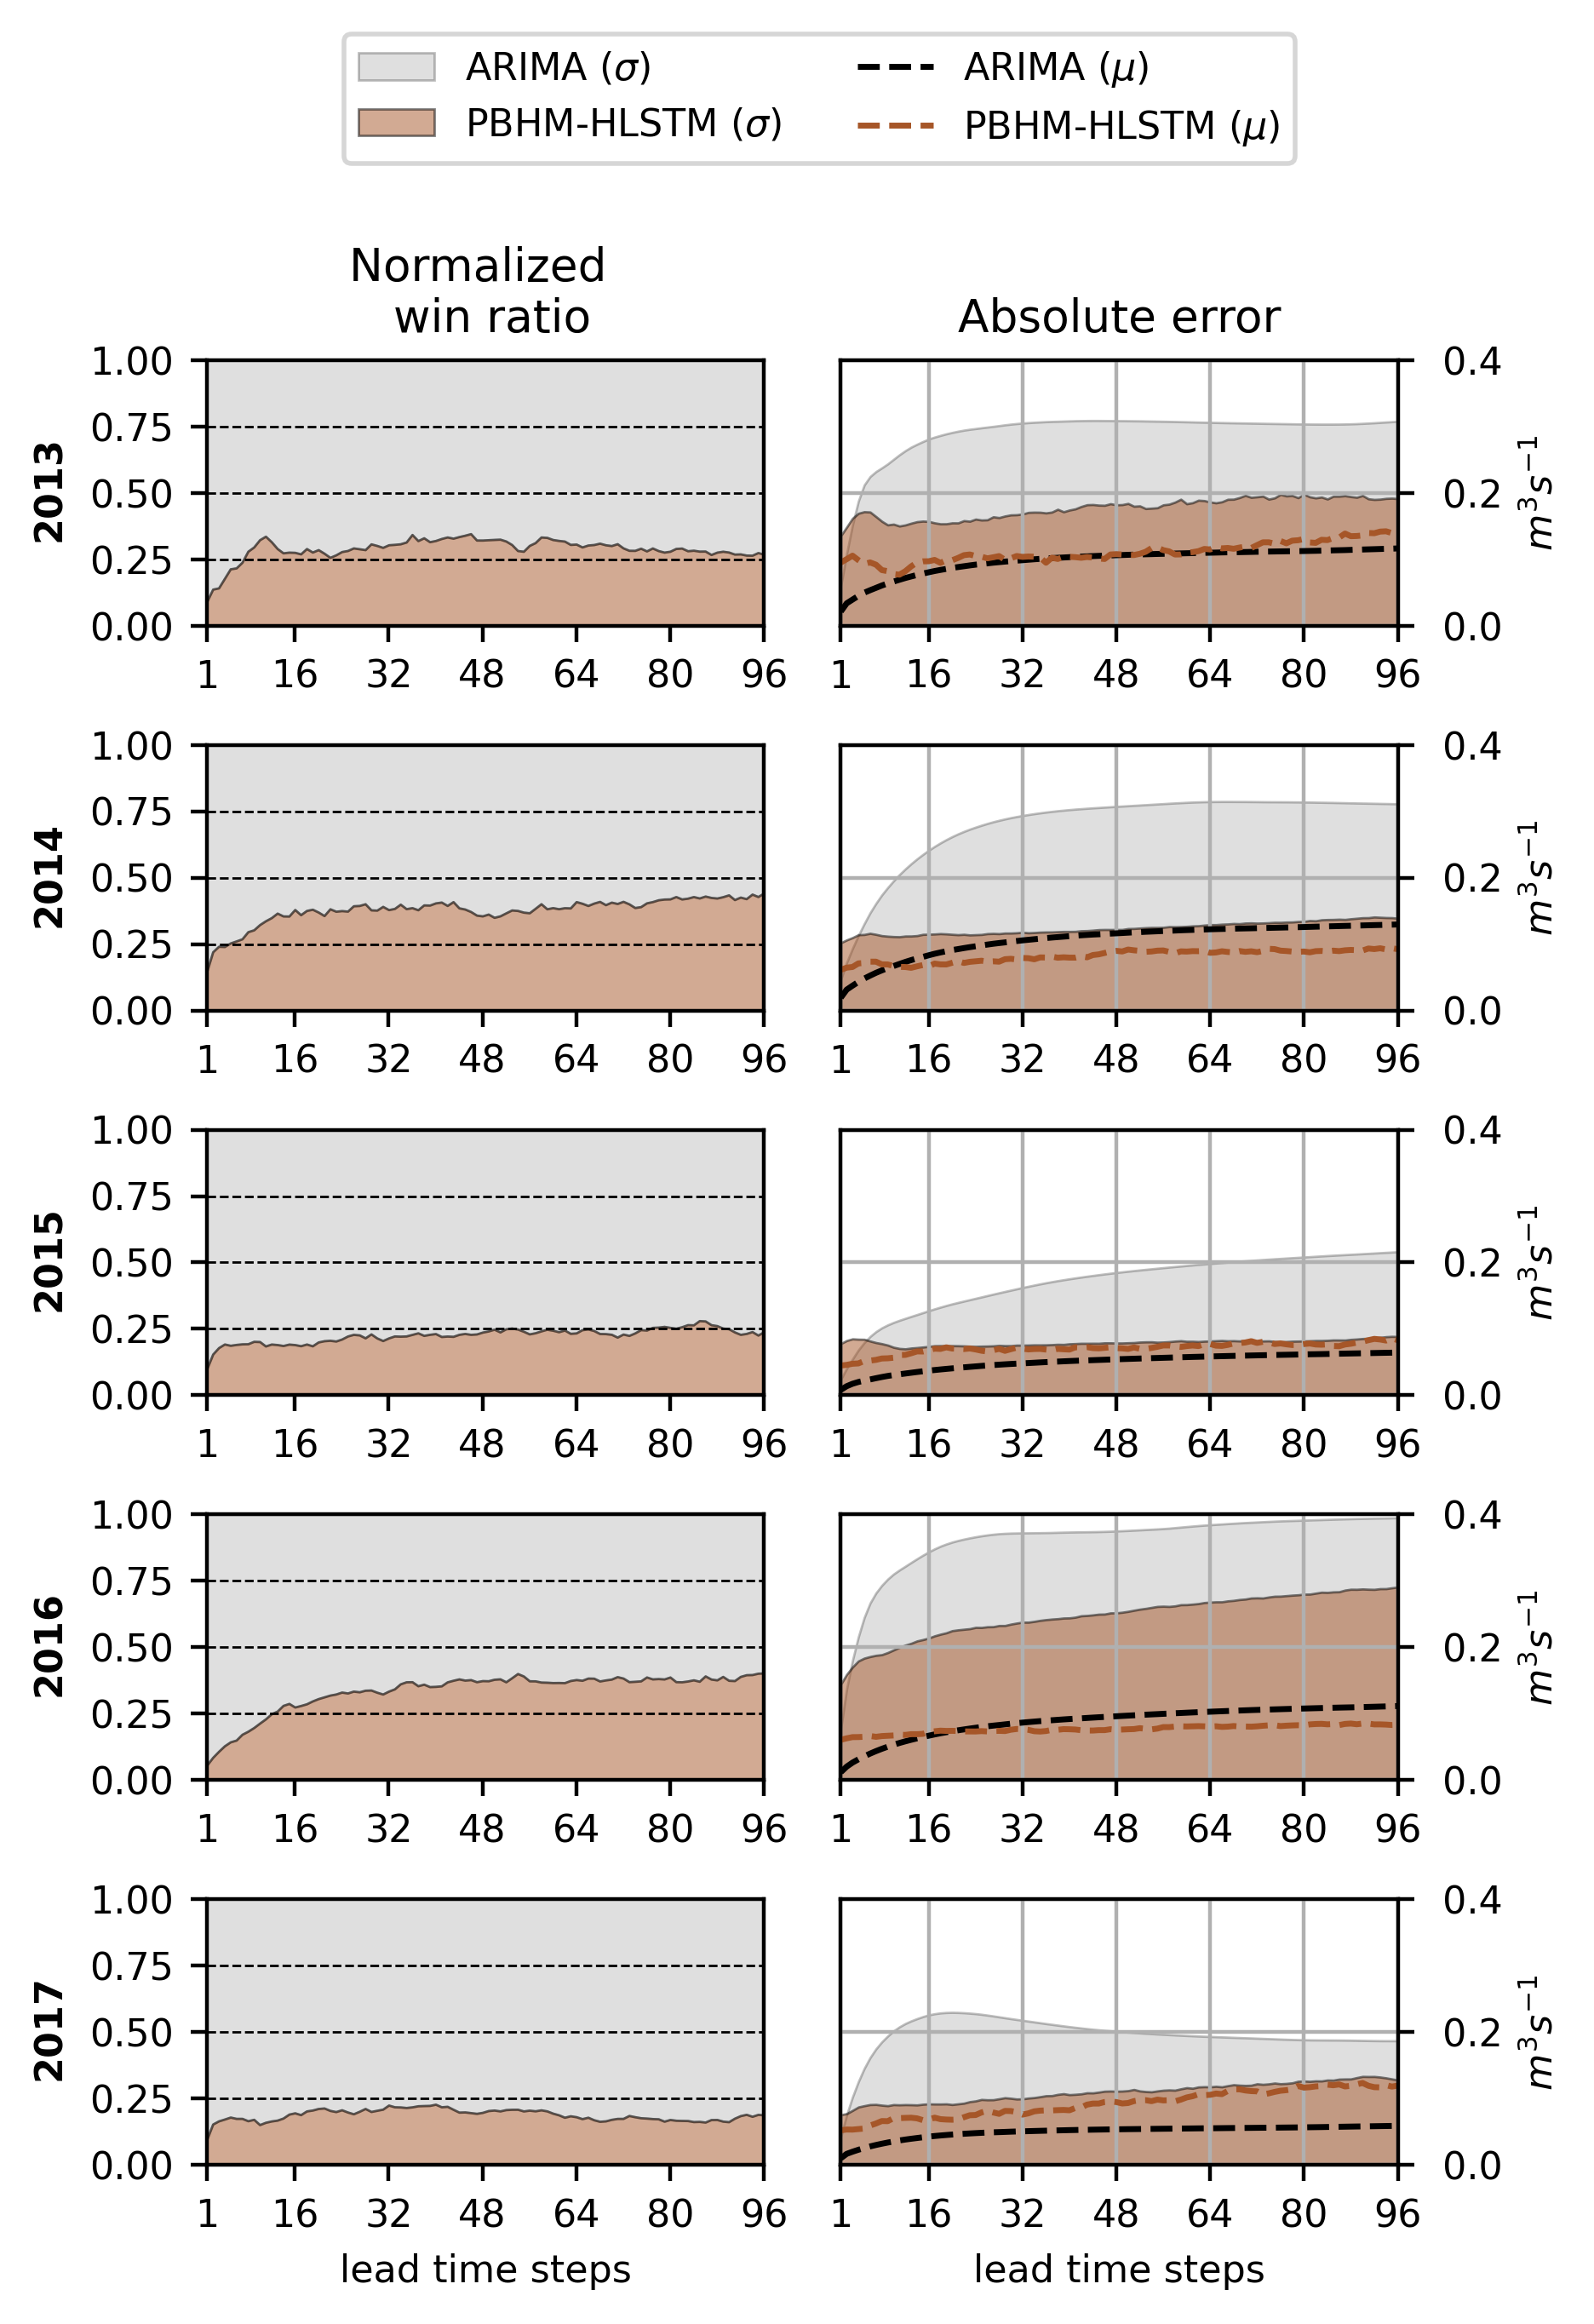

In [4]:
# create summary dataframe
df = pd.DataFrame(index=np.arange(2013,2018,dtype=int))

# process all folds
filepaths_lstm = [os.path.join(models["pbhm-hlstm"].lg_path, f"forecast_{x:d}.pkl") for x in range(2013,2018)]

filepaths_arima = [os.path.join(models["arima-boxcox"].lg_path, f"forecast_{x:d}.pkl") for x in range(2013,2018)]

date_ranges = [['2013-01-06 00:00:00','2013-12-27 00:00:00'],
               ['2014-01-06 00:00:00','2014-12-27 00:00:00'],
               ['2015-01-06 00:00:00','2015-12-27 00:00:00'],
               ['2016-01-06 00:00:00','2016-12-27 00:00:00'],
               ['2017-01-06 00:00:00','2017-12-27 00:00:00']]

all_error_folds_arima = []
all_error_folds_lstm = []
all_norm_arima = []
all_norm_hydro = []
all_norm_lstm = []

for i in range(0,len(filepaths_lstm)):
    year = 2013 + i

    data_lstm = pd.read_pickle(filepaths_lstm[i])
    data_arima = pd.read_pickle(filepaths_arima[i])
    
    # FIX UTC ------------------------------------------------------
    data_arima.index = pd.date_range(data_arima.index[0], data_arima.index[-1], freq="15min", tz="UTC")

    data_lstm_filtered = data_lstm.sort_index().loc[date_ranges[i][0]:date_ranges[i][1]]
    data_arima_filtered = data_arima.sort_index().loc[date_ranges[i][0]:date_ranges[i][1]]

    all_best_list, normalized_arima, normalized_lstm, all_errors_arima, all_errors_lstm = find_best_models(data_lstm_filtered, data_arima_filtered)

    all_error_folds_arima.append(all_errors_arima)
    all_error_folds_lstm.append(all_errors_lstm)
    all_norm_arima.append(normalized_arima)
    all_norm_lstm.append(normalized_lstm)
    
    # percentage of ARIMA wins
    add_up = np.sum(all_best_list, axis=0)
    df.loc[year, "arima_first_step_wins_percent"] = all_best_list[0][0] / np.sum(all_best_list, axis=1)[0]
    df.loc[year, "arima_wins_percent"] = add_up[0] / np.sum(add_up)
    # lead time steps to outperform ARIMA in direct wins
    out_perform_idxs = [n for n, (x,y) in enumerate(all_best_list) if y-x > 0]
    if len(out_perform_idxs) > 0:
        df.loc[year, "wins"]       = out_perform_idxs[0]
        df.loc[year, "wins_hours"] = out_perform_idxs[0]*0.25
    else:
        df.loc[year, "wins"]       = -1
        df.loc[year, "wins_hours"] = -1
    # lead time steps to outperform ARIMA in AE
    out_perform_idxs = [n for n, (x,y) in enumerate(zip(
            np.mean(all_errors_arima, axis=1), 
            np.mean(all_errors_lstm, axis=1)
        )) if y-x < 0]
    if len(out_perform_idxs) > 0:
        df.loc[year, "ae"]       = out_perform_idxs[0]
        df.loc[year, "ae_hours"] = out_perform_idxs[0]*0.25
    else:
        df.loc[year, "ae"]       = -1
        df.loc[year, "ae_hours"] = -1
    # lead time steps to outperform ARIMA in sigma
    out_perform_idxs = [n for n, (x,y) in enumerate(zip(
            np.std(all_errors_arima, axis=1), 
            np.std(all_errors_lstm, axis=1)
        )) if y-x < 0]
    if len(out_perform_idxs) > 0:
        df.loc[year, "sigma"]       = out_perform_idxs[0]
        df.loc[year, "sigma_hours"] = out_perform_idxs[0]*0.25
    else:
        df.loc[year, "sigma"]       = -1
        df.loc[year, "sigma_hours"] = -1
 
fig, axes = plt.subplots(5,2,figsize=(4.72,6.5), dpi=400)

num_entries = 96

x_values = np.arange(1,97)

k = 0
for i in range(0,5):
        
    x = np.arange(1,97)
    y_mean = np.asarray([np.mean(elem) for elem in all_error_folds_arima[k]])
    y_std = np.asarray([np.std(elem) for elem in all_error_folds_arima[k]])
    
    y_mean_lstm = np.asarray([np.mean(elem) for elem in all_error_folds_lstm[k]])
    y_std_lstm = np.asarray([np.std(elem) for elem in all_error_folds_lstm[k]])
    
    axes[i,1].plot(x, y_mean, color='black', linestyle = '--', label='ARIMA ($\mu$)', linewidth=1.25)
    axes[i,1].fill_between(x, y_std, y2=0,  color='grey', label='ARIMA', alpha=0.25, edgecolor='black', linewidth=0.5)
    
    axes[i,1].plot(x, y_mean_lstm, color='#a65628', linestyle = '--', label='LSTM-PBHM ($\mu$)', linewidth=1.25)
    axes[i,1].fill_between(x, y_std_lstm, y2=0, color='#a65628', label='HLSTM-PBHM', alpha=0.5, edgecolor='black', linewidth=0.5)
    
    axes[i,1].set_xticks(np.array([1,16,32,48,64,80,96]))
    axes[i,1].set_yticks(np.array([0.0,0.2,0.4]))
    axes[i,1].set_ylim(0,0.4)
    axes[i,1].set_xticks(np.array([1, 16, 32, 48, 64, 80, 96]))
    axes[i,1].set_xlim(1, 96)
    axes[i,1].grid()
    
    axes[i,1].yaxis.set_major_formatter('{x: 4.1f}')
    axes[i,1].set_ylabel("$m^3s^{-1}$")
    axes[i,1].yaxis.set_label_position("right")
    axes[i,1].yaxis.set_ticks_position("right")
    
    k += 1
    
k = 0
for i in range(0,5):
   
    axes[i,0].fill_between(x_values, y1=all_norm_lstm[k], y2=1, label='ARIMA ($\sigma$)', color = 'grey',edgecolor='black', linewidth=0.5, alpha=0.25)
    axes[i,0].fill_between(x_values, y1=all_norm_lstm[k], y2=0, label='PBHM-HLSTM ($\sigma$)', color = '#a65628',edgecolor='black', linewidth=0.5, alpha=0.5)

    axes[i,0].plot([], [], color= 'black', linestyle = '--', label='ARIMA ($\mu$)', linewidth=1.25)
    axes[i,0].plot([], [], color= '#a65628', linestyle = '--', label='PBHM-HLSTM ($\mu$)', linewidth=1.25)

    axes[i,0].set_ylabel(r"$\bf{"+f"{2013 + i}"+r"}$")
    axes[i,0].set_xticks(np.array([1, 16,32,48,64,80,96]))
    axes[i,0].set_ylim(0,1)
    axes[i,0].set_xticks(np.array([1, 16, 32, 48, 64, 80, 96]))
    axes[i,0].set_ylim(0, 1)
    axes[i,0].set_xlim(1, 96)
    axes[i,0].set_yticks([0, 0.25,0.5,0.75,1.0])
    axes[i,0].grid(axis='y', linestyle='--', color='black', linewidth=0.5)

    k += 1

axes[4,0].set_xlabel('lead time steps')
axes[4,1].set_xlabel('lead time steps')
axes[0,0].set_title('Normalized \n win ratio')
axes[0,1].set_title("Absolute error")

plt.tight_layout()
plt.subplots_adjust(top=0.89)
axes[0,0].legend(bbox_to_anchor=(1.1, 1.6),
                  loc='lower center', ncol=2, 
                  borderaxespad=1)

In [5]:
fig.savefig(os.path.join(PLOT_PATH, 'fig6_directandband_annual_ae.png'), bbox_inches="tight", dpi=300)

In [6]:
df

,arima_first_step_wins_percent,arima_wins_percent,wins,wins_hours,ae,ae_hours,sigma,sigma_hours
2013,0.908424,0.710299,-1.0,-1.0,35.0,8.75,3.0,0.75
2014,0.851677,0.621462,-1.0,-1.0,10.0,2.50,4.0,1.00
2015,0.899886,0.774158,-1.0,-1.0,-1.0,-1.00,5.0,1.25
2016,0.944085,0.664797,-1.0,-1.0,20.0,5.00,2.0,0.50
2017,0.903876,0.812489,-1.0,-1.0,-1.0,-1.00,2.0,0.50


In [7]:
df.median()

arima_first_step_wins_percent     0.903876
arima_wins_percent                0.710299
wins                             -1.000000
wins_hours                       -1.000000
ae                               10.000000
ae_hours                          2.500000
sigma                             3.000000
sigma_hours                       0.750000
dtype: float64